# Redes Neuronales Recurrentes aplicadas a la calidad del agua

De acuerdo al planteamiento pedido para la toma de datos en este caso la generacion de un dataset sintetico respecto a la calidad del agua se revisó el siguiente documento `https://www.bivica.org/files/normativa-calidad-agua.pdf` sobre la normativa nacional de los riquisitos del agua donde es posible determinar los campos fisicos, organolepticos, quimicos, parametros de desinfeccion, plaguicidas, radioactividad, microbiologicos y de control referencial, se tomo en cuenta para la primera instancia los valores de control refencial y los requisitos fisicos dado que estos demostraran el proceso por el cual el agua pasa para asegurar su potabilidad teniendo como referencia la calidad del agua previo tratamiento y post tratamiento.

### Importacion de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

### Generacion del dataset sintetico

In [2]:
def generate_water_quality_data(batch_size, n_steps):
    conductivity = 1500.0  # µS/cm
    alkalinity = 370.0  # mg/L CaCO3
    langelier_index = np.random.uniform(-0.5, 0.5, size=(batch_size, 1))

    time = np.linspace(0, 1, n_steps)
    
    conductivity_data = conductivity + 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    alkalinity_data = alkalinity + 0.05 * (np.random.rand(batch_size, n_steps) - 0.5)
    
    alkalinity_data *= (1 + langelier_index * 0.2)  
    
    color_data = 15 + 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    turbidity_data = 5 + 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    dissolved_solids_data = 1000 + 10 * (np.random.rand(batch_size, n_steps) - 0.5)
    
    return np.concatenate([conductivity_data[..., np.newaxis], 
                            alkalinity_data[..., np.newaxis],
                            color_data[..., np.newaxis],
                            turbidity_data[..., np.newaxis],
                            dissolved_solids_data[..., np.newaxis]], axis=-1).astype(np.float32)

In [3]:
n_steps = 50
water_quality_data = generate_water_quality_data(43800, n_steps + 1)

X_train, y_train = water_quality_data[:30660, :n_steps], water_quality_data[:30660, -1]
X_valid, y_valid = water_quality_data[30660:39480, :n_steps], water_quality_data[30660:39480, -1]
X_test, y_test = water_quality_data[39480:, :n_steps], water_quality_data[39480:, -1]
X_train.shape, y_train.shape

((30660, 50, 5), (30660, 5))

In [4]:
print (water_quality_data)

[[[1500.0361     334.7466      14.950909     4.989907   997.5803   ]
  [1500.0087     334.77383     14.996071     4.9589057  997.9571   ]
  [1499.9504     334.76474     15.007265     4.973862  1004.45306  ]
  ...
  [1499.9886     334.77753     14.951381     5.046669   996.62756  ]
  [1500.0068     334.74072     14.989375     4.9615993 1000.69037  ]
  [1500.0188     334.75967     15.047425     5.017037   997.0582   ]]

 [[1499.9777     345.75635     15.013935     5.0200205  995.67285  ]
  [1499.9696     345.76636     15.046015     4.973733   998.05963  ]
  [1499.9762     345.76398     15.017523     5.0427694  995.10114  ]
  ...
  [1499.9841     345.73734     15.0457325    4.977052   997.0682   ]
  [1500.0089     345.74863     14.97811      5.039363   997.08765  ]
  [1500.0264     345.73166     15.026169     5.040726  1003.21405  ]]

 [[1499.9967     334.06375     14.99665      5.0249    1004.86884  ]
  [1499.9558     334.0757      14.983661     4.9891677 1001.8759   ]
  [1499.9954     3

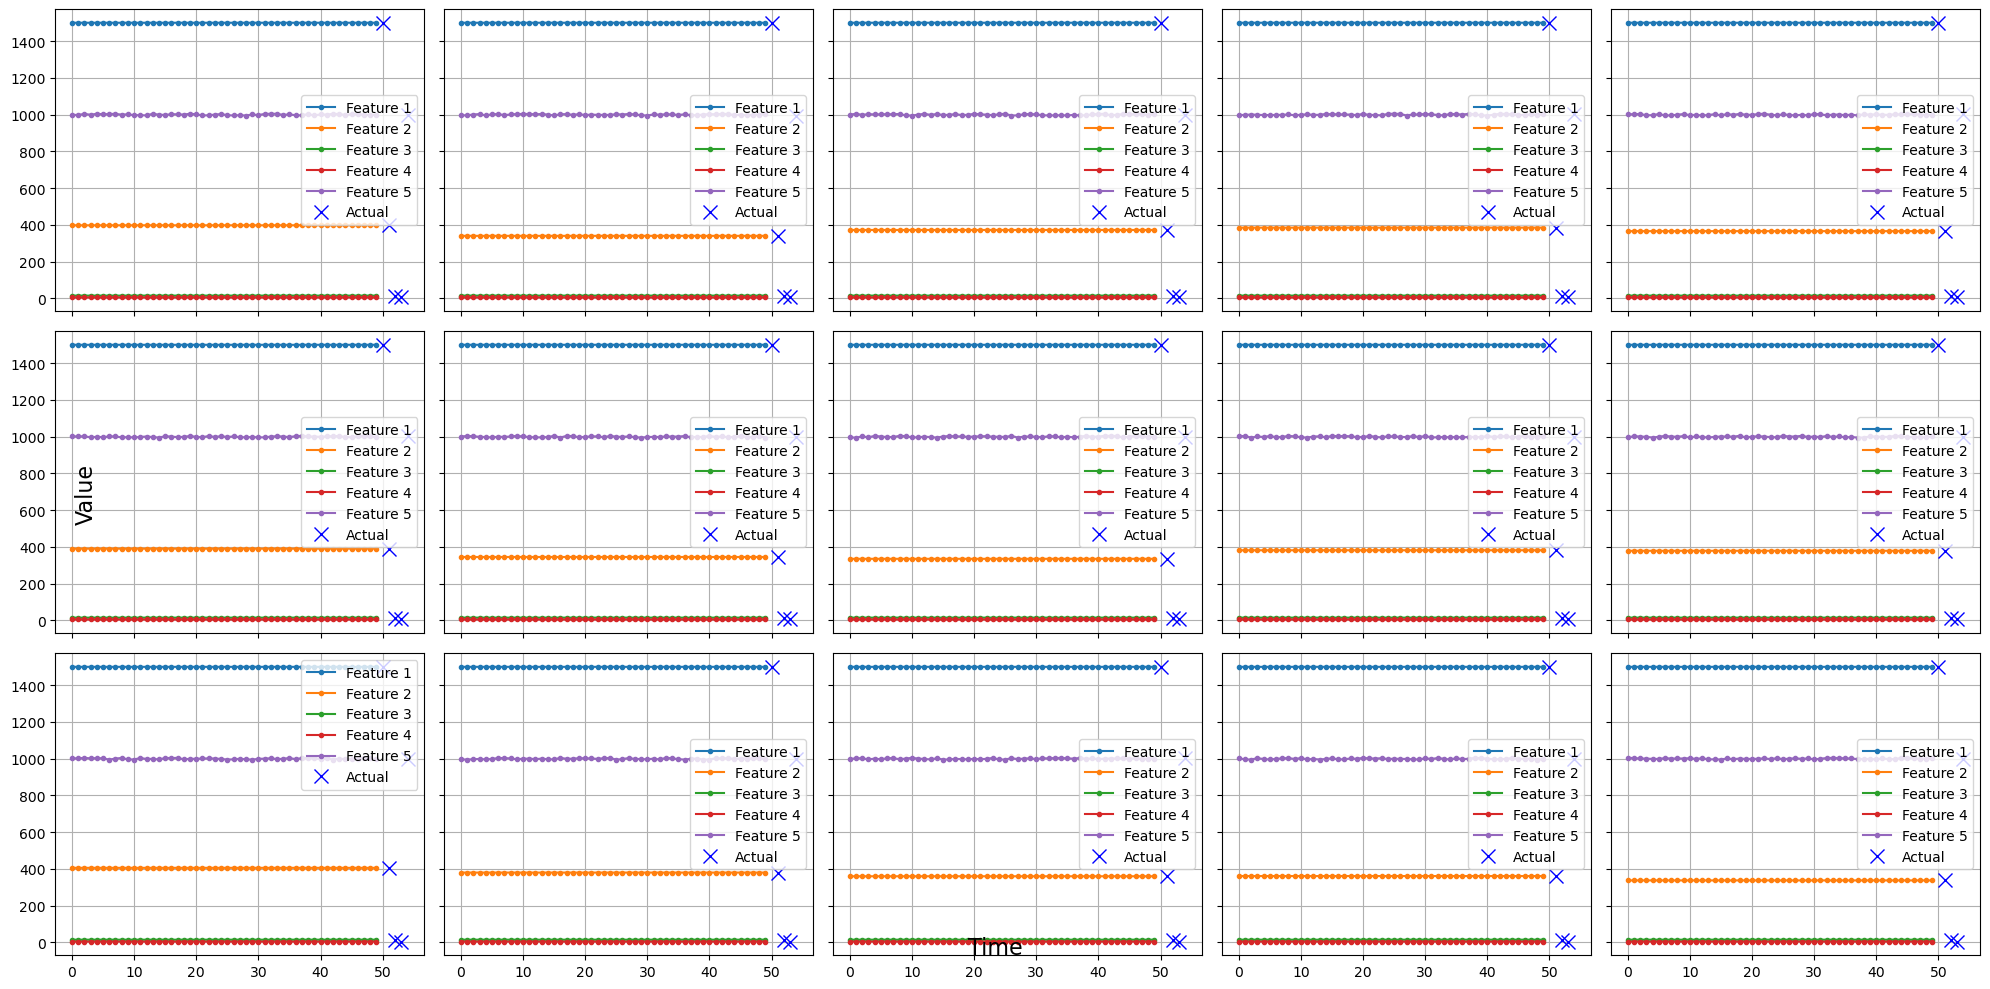

In [5]:
def plot_water_quality_data(X, y, y_pred=None, y_pred_std=None, x_label="Time", y_label="Value"):
    batch_size, n_steps, n_features = X.shape
    
    num_plots = min(batch_size, 15)
    num_cols = 5
    num_rows = (num_plots - 1) // num_cols + 1
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, sharex=True, figsize=(20, 10))
    
    for i in range(num_plots):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        for feature_idx in range(n_features):
            ax.plot(X[i, :, feature_idx], ".-", label=f'Feature {feature_idx + 1}')
        
        if y is not None:
            ax.plot(range(n_steps, n_steps+len(y[i])), y[i], "bx", markersize=10, label='Actual')
        
        if y_pred is not None:
            ax.plot(range(n_steps, n_steps+len(y_pred[i])), y_pred[i], "ro", label='Predicted')
        
        if y_pred_std is not None:
            ax.plot(range(n_steps, n_steps+len(y_pred[i])), y_pred[i] + y_pred_std[i], 'r--', alpha=0.5)
            ax.plot(range(n_steps, n_steps+len(y_pred[i])), y_pred[i] - y_pred_std[i], 'r--', alpha=0.5)
        
        ax.grid(True)
        ax.legend()
    
    for ax in axes.flat:
        ax.label_outer()
    
    fig.text(0.5, 0.04, x_label, ha='center', fontsize=16)
    fig.text(0.04, 0.5, y_label, va='center', rotation='vertical', fontsize=16)
    
    plt.tight_layout()
    plt.show()

plot_water_quality_data(X_test, y_test)

En este caso específico se tomaron en cuenta estos 5 valores para la calidad del agua. Sin embargo, luego de una investigación pertinente y además de consultar con expertos en el área, el 90% de estos valores, generales en la toma de calidad de agua potable, ya son estándares. Estos estándares no cambiarán a menos que se realicen modificaciones en la planta potabilizadora. Por lo tanto, querer predecir usando todos los valores presentados en el compendio y la guía nos llevará a predecir valores irreales e inútiles. La variable para obtener los valores reales es un cálculo muy diferente, acorde al agua de lluvia, al estudio de ríos y a una cantidad gigantesca de variables atmosféricas y de calidad de materiales. Por lo tanto, se tomará en cuenta solo la turbidez final, que es el resultado esperado después de todo el proceso químico ya estandarizado del agua, para determinar así la calidad del agua de entrada y la salida ya procesada.

Una vez definida la variable a considerar en este momento, procedemos a utilizar todas las técnicas de mejora para obtener los mejores resultados posibles.

In [6]:
def generate_turbidity_data(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise

    
    min_turbidity = 0
    max_turbidity = 5
    series_min = np.min(series, axis=1, keepdims=True)
    series_max = np.max(series, axis=1, keepdims=True)
    scaled_series = min_turbidity + ((series - series_min) * (max_turbidity - min_turbidity)) / (series_max - series_min)

    return scaled_series[..., np.newaxis].astype(np.float32)


In [7]:
n_steps = 50
series = generate_turbidity_data(43800, n_steps + 10)

X_train = series[:30660, :n_steps]
X_valid = series[30660:39480, :n_steps]
X_test = series[39480:, :n_steps]

Y = np.empty((43800, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:30660]
Y_valid = Y[30660:39480]
Y_test = Y[39480:]

X_train = X_train.reshape(-1, n_steps, 1)
X_valid = X_valid.reshape(-1, n_steps, 1)
X_test = X_test.reshape(-1, n_steps, 1)

Y_train = Y_train.reshape(-1, n_steps, 10)
Y_valid = Y_valid.reshape(-1, n_steps, 10)
Y_test = Y_test.reshape(-1, n_steps, 10)



In [8]:
print (series)

[[[1.8746058 ]
  [2.19194   ]
  [2.651831  ]
  ...
  [5.        ]
  [4.8149586 ]
  [4.670265  ]]

 [[2.2807794 ]
  [1.663322  ]
  [1.2214836 ]
  ...
  [5.        ]
  [4.8964815 ]
  [4.539913  ]]

 [[2.1442676 ]
  [1.975724  ]
  [2.3326845 ]
  ...
  [2.522649  ]
  [2.6344056 ]
  [2.632844  ]]

 ...

 [[3.2412999 ]
  [3.5263135 ]
  [3.4438057 ]
  ...
  [1.5907305 ]
  [1.052096  ]
  [0.37335673]]

 [[4.4615602 ]
  [4.813834  ]
  [5.        ]
  ...
  [0.25859246]
  [0.69800246]
  [0.9363393 ]]

 [[3.0654604 ]
  [3.539878  ]
  [4.348693  ]
  ...
  [2.4225607 ]
  [1.8951808 ]
  [1.8567294 ]]]


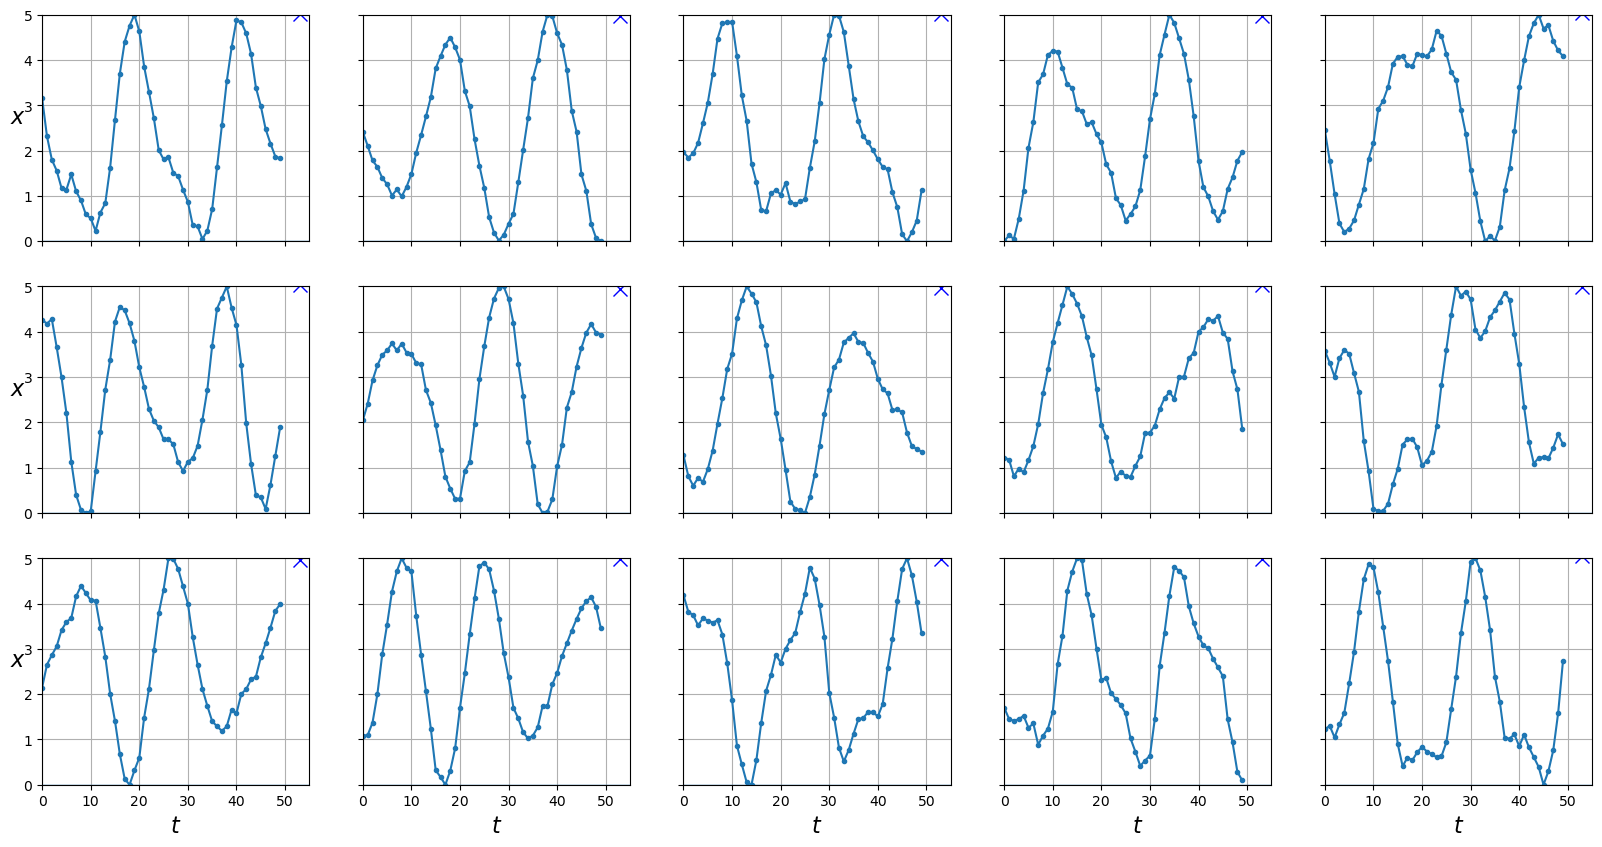

In [9]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row * c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :]) + len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :]) + len(y[ix]), 0, 5])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test)


In [10]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

def predict(model, dataloader):
    model.eval() 
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [12]:

class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [13]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y
class GRU(DeepRNN):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.GRU(input_size=1, hidden_size=20, num_layers=2, dropout=dropout, batch_first=True)
    
gru = GRU()

In [14]:
gru.rnn.weight_ih_l0.shape, gru.rnn.bias_ih_l0.shape

(torch.Size([60, 1]), torch.Size([60]))

In [15]:
gru.rnn.weight_hh_l0.shape, gru.rnn.bias_hh_l0.shape

(torch.Size([60, 20]), torch.Size([60]))

In [16]:
# salida y capas ocultas (short term y long term)

output, h = gru.rnn(torch.randn(10, 50, 1))

# dims -> [num_layers, batch_size, len_seq]
h.shape

torch.Size([2, 10, 20])

In [17]:
gru = GRU()
fit(gru, dataloader)

loss 0.43679 loss_last_step 0.22516 val_loss 0.43994 val_loss_last_step 0.23267: 100%|██████████| 10/10 [03:15<00:00, 19.58s/it]


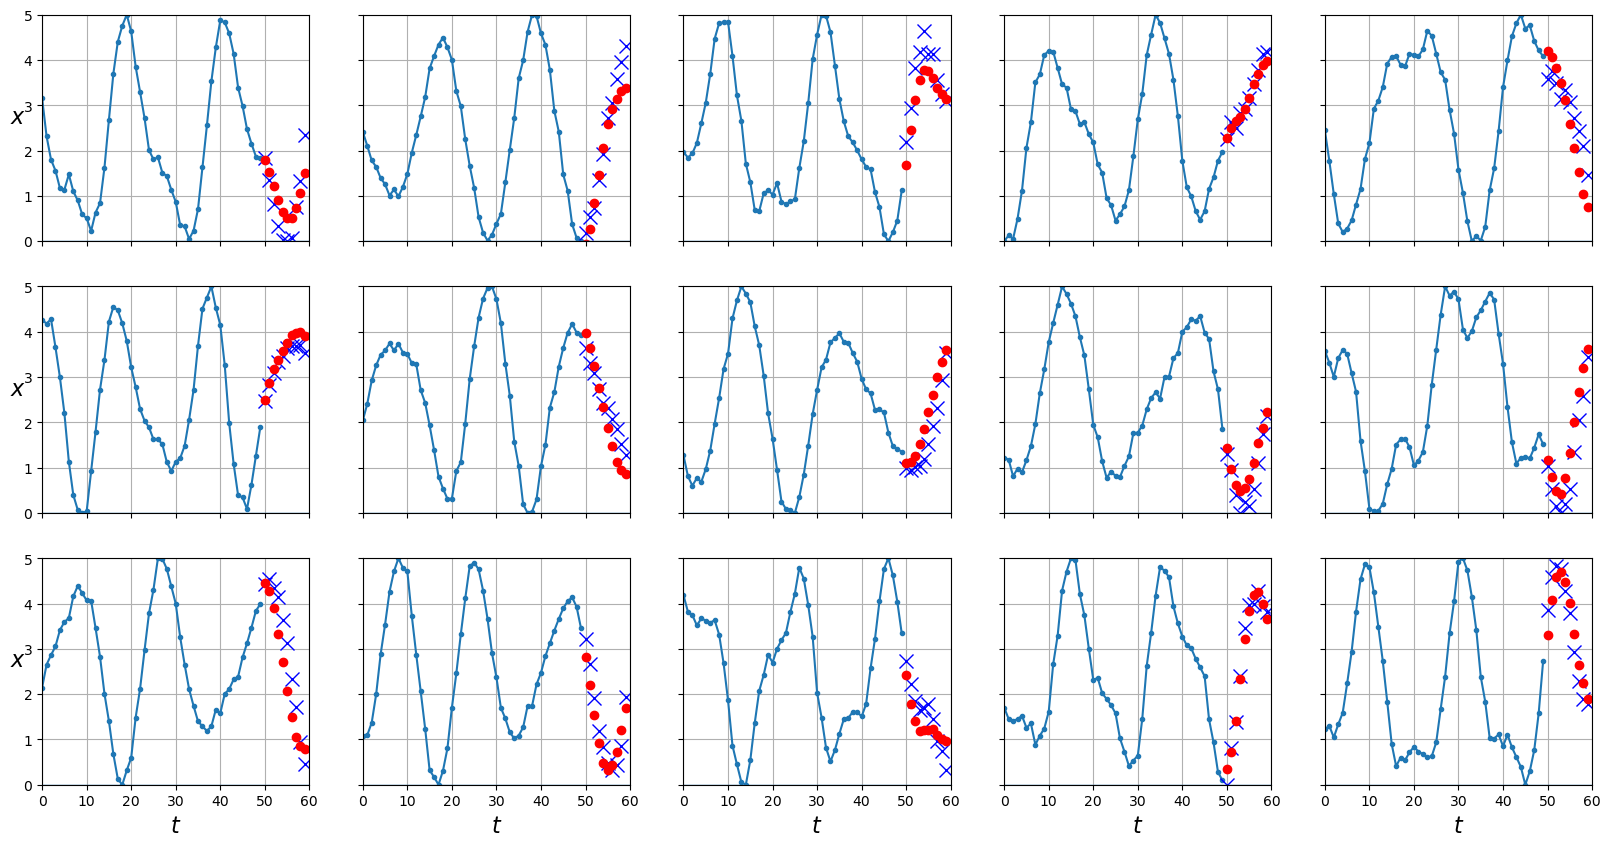

0.23462808

In [18]:
y_pred = predict(gru, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())